# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=15,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-34-47/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4835 | MulticlassF1Score=0.1268
Batch-30 : CrossEntropyLoss=2.4432 | MulticlassF1Score=0.1915
Batch-45 : CrossEntropyLoss=2.4525 | MulticlassF1Score=0.2470
Batch-60 : CrossEntropyLoss=2.4637 | MulticlassF1Score=0.2779
Batch-75 : CrossEntropyLoss=2.4086 | MulticlassF1Score=0.3135
Batch-90 : CrossEntropyLoss=2.4282 | MulticlassF1Score=0.3415
Batch-105: CrossEntropyLoss=2.4329 | MulticlassF1Score=0.3602
Batch-120: CrossEntropyLoss=2.3876 | MulticlassF1Score=0.3784
Batch-135: CrossEntropyLoss=2.3578 | MulticlassF1Score=0.4076
Batch-150: CrossEntropyLoss=2.3484 | MulticlassF1Score=0.4338
Batch-165: CrossEntropyLoss=2.3427 | MulticlassF1Score=0.4545
Batch-180: CrossEntropyLoss=2.3669 | MulticlassF1Score=0.4718
Batch-195: CrossEntropyLoss=2.3554 | MulticlassF1Score=0.4870
Batch-210: CrossEntropyLoss=2.3574 | MulticlassF1Score=0.5004
Batch-225: CrossEntropyLoss=2.3393 | MulticlassF1Score=0.5132
Batch-226: CrossEntropyLoss=2.3459 | MulticlassF1Score=0.5138

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3299 | MulticlassF1Score=0.7058
Batch-30 : CrossEntropyLoss=2.3527 | MulticlassF1Score=0.7039
Batch-45 : CrossEntropyLoss=2.3324 | MulticlassF1Score=0.7080
Batch-60 : CrossEntropyLoss=2.3382 | MulticlassF1Score=0.7049
Batch-63 : CrossEntropyLoss=2.3280 | MulticlassF1Score=0.7044

Training   : Mean CrossEntropyLoss = 2.4087 | Mean MulticlassF1Score = 0.3526
Validation : Mean CrossEntropyLoss = 2.3410 | Mean MulticlassF1Score = 0.7042

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3373 | MulticlassF1Score=0.7036
Batch-30 : CrossEntropyLoss=2.3495 | MulticlassF1Score=0.7079
Batch-45 : CrossEntropyLoss=2.3267 | MulticlassF1Score=0.7114
Batch-60 : CrossEntropyLoss=2.3253 | MulticlassF1Score=0.7137
Batch-75 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.7169
Batch-90 : CrossEntropyLoss=2.3231 | MulticlassF1Score=0.7239
Batch-105: CrossEntropyLoss=2.3221 | MulticlassF1Score=0.7309
Batch-120: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7365
Batch-135: CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7416
Batch-150: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.7464
Batch-165: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7500
Batch-180: CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7539
Batch-195: CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7566
Batch-210: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.7591
Batch-225: CrossEntropyLoss=2.3218 | MulticlassF1Score=0.7617
Batch-226: CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7617

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7846
Batch-30 : CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7876
Batch-45 : CrossEntropyLoss=2.3234 | MulticlassF1Score=0.7874
Batch-60 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7875
Batch-63 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7876

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3225 | Mean MulticlassF1Score = 0.7325
Validation : Mean CrossEntropyLoss = 2.3137 | Mean MulticlassF1Score = 0.7852

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3161 | MulticlassF1Score=0.7997
Batch-30 : CrossEntropyLoss=2.3149 | MulticlassF1Score=0.7965
Batch-45 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7919
Batch-60 : CrossEntropyLoss=2.3165 | MulticlassF1Score=0.7921
Batch-75 : CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7940
Batch-90 : CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7925
Batch-105: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.7927
Batch-120: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7940
Batch-135: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.7952
Batch-150: CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7952
Batch-165: CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7944
Batch-180: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.7949
Batch-195: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.7948
Batch-210: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7947
Batch-225: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7942
Batch-226: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7941

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7883
Batch-30 : CrossEntropyLoss=2.3212 | MulticlassF1Score=0.7902
Batch-45 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7892
Batch-60 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.7913
Batch-63 : CrossEntropyLoss=2.3162 | MulticlassF1Score=0.7911

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3118 | Mean MulticlassF1Score = 0.7950
Validation : Mean CrossEntropyLoss = 2.3124 | Mean MulticlassF1Score = 0.7886

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7909
Batch-30 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.7942
Batch-45 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7957
Batch-60 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7955
Batch-75 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7973
Batch-90 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7984
Batch-105: CrossEntropyLoss=2.3023 | MulticlassF1Score=0.7980
Batch-120: CrossEntropyLoss=2.3175 | MulticlassF1Score=0.7974
Batch-135: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.7978
Batch-150: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.7992
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8000
Batch-180: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8009
Batch-195: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.8011
Batch-210: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8018
Batch-225: CrossEntropyLoss=2.3173 | MulticlassF1Score=0.8019
Batch-226: CrossEntropyLoss=2.3165 | MulticlassF1Score=0.8019

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8066
Batch-30 : CrossEntropyLoss=2.3085 | MulticlassF1Score=0.8051
Batch-45 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8020
Batch-60 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8019
Batch-63 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8027

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3092 | Mean MulticlassF1Score = 0.7972
Validation : Mean CrossEntropyLoss = 2.3086 | Mean MulticlassF1Score = 0.8041

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8080
Batch-30 : CrossEntropyLoss=2.3105 | MulticlassF1Score=0.8137
Batch-45 : CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8145
Batch-60 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8179
Batch-75 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8231
Batch-90 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8258
Batch-105: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8275
Batch-120: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8283
Batch-135: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8297
Batch-150: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8307
Batch-165: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8311
Batch-180: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8318
Batch-195: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8320
Batch-210: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8323
Batch-225: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8328
Batch-226: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8328

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8343
Batch-30 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8316
Batch-45 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8315
Batch-60 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8319
Batch-63 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8323

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8248
Validation : Mean CrossEntropyLoss = 2.2994 | Mean MulticlassF1Score = 0.8315

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8406
Batch-30 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8435
Batch-45 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8413
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8402
Batch-75 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8406
Batch-90 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8401
Batch-105: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8398
Batch-120: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8399
Batch-135: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8401
Batch-150: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8401
Batch-165: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8405
Batch-180: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8395
Batch-195: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8399
Batch-210: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8401
Batch-225: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8402
Batch-226: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8299
Batch-30 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8308
Batch-45 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8320
Batch-60 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8333
Batch-63 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8338

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8405
Validation : Mean CrossEntropyLoss = 2.2988 | Mean MulticlassF1Score = 0.8312

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8372
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8469
Batch-45 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8531
Batch-60 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8562
Batch-75 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8590
Batch-90 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8612
Batch-105: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8616
Batch-120: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8620
Batch-135: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8628
Batch-150: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8640
Batch-165: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8641
Batch-180: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8646
Batch-195: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8646
Batch-210: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8651
Batch-225: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8651
Batch-226: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8630
Batch-30 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8641
Batch-45 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8625
Batch-60 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8611
Batch-63 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8613

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2897 | Mean MulticlassF1Score = 0.8583
Validation : Mean CrossEntropyLoss = 2.2905 | Mean MulticlassF1Score = 0.8633

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8690
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8695
Batch-45 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8697
Batch-60 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8706
Batch-75 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8703
Batch-90 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8701
Batch-105: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8705
Batch-120: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8708
Batch-135: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8710
Batch-150: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8713
Batch-165: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8714
Batch-180: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8711
Batch-195: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8711
Batch-210: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8713
Batch-225: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8711
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8677
Batch-30 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8618
Batch-45 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8637
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8638
Batch-63 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8633

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2877 | Mean MulticlassF1Score = 0.8706
Validation : Mean CrossEntropyLoss = 2.2900 | Mean MulticlassF1Score = 0.8650

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8765
Batch-30 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8763
Batch-45 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8748
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8747
Batch-75 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8751
Batch-90 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8745
Batch-105: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8748
Batch-120: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8753
Batch-135: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8755
Batch-150: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8753
Batch-165: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8750
Batch-180: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8743
Batch-195: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8739
Batch-210: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8736
Batch-225: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8737
Batch-226: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8736

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8624
Batch-30 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8639
Batch-45 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8637
Batch-60 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8640
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8644

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2868 | Mean MulticlassF1Score = 0.8748
Validation : Mean CrossEntropyLoss = 2.2894 | Mean MulticlassF1Score = 0.8620

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8778
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8769
Batch-45 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8743
Batch-60 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8748
Batch-75 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8752
Batch-90 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8758
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8753
Batch-120: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8753
Batch-135: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8750
Batch-150: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8758
Batch-165: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8756
Batch-180: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8758
Batch-195: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8755
Batch-210: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8756
Batch-225: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8765
Batch-226: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8765

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8792
Batch-30 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8762
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8769
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8795
Batch-63 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8796

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2859 | Mean MulticlassF1Score = 0.8757
Validation : Mean CrossEntropyLoss = 2.2852 | Mean MulticlassF1Score = 0.8788

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8930
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8941
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8926
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8922
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8919
Batch-90 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8922
Batch-105: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8924
Batch-120: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8928
Batch-135: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8928
Batch-150: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8924
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8921
Batch-180: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8920
Batch-195: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8920
Batch-210: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8922
Batch-225: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8922
Batch-226: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8922

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8860
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8830
Batch-45 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8838
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8834
Batch-63 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8832

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8926
Validation : Mean CrossEntropyLoss = 2.2838 | Mean MulticlassF1Score = 0.8846

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8916
Batch-30 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8903
Batch-45 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8907
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8921
Batch-75 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8932
Batch-90 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8933
Batch-105: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8940
Batch-120: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8944
Batch-135: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8942
Batch-150: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8945
Batch-165: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8946
Batch-180: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.8946
Batch-195: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8948
Batch-210: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8945
Batch-225: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8943
Batch-226: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8943

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8863
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8798
Batch-45 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8803
Batch-60 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8824
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8825

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2805 | Mean MulticlassF1Score = 0.8935
Validation : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8824

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8935
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8950
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8952
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8959
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8962
Batch-90 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8957
Batch-105: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8963
Batch-120: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8967
Batch-135: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8963
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8962
Batch-165: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8958
Batch-180: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.8961
Batch-195: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8959
Batch-210: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8959
Batch-225: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8959
Batch-226: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8959

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8850
Batch-30 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8843
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8833
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8832
Batch-63 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8828

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8953
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8837

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9018
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9012
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9002
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8997
Batch-75 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8984
Batch-90 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8988
Batch-105: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8983
Batch-120: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8976
Batch-135: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8972
Batch-150: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8974
Batch-165: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8976
Batch-180: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8977
Batch-195: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8975
Batch-210: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8974
Batch-225: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8972
Batch-226: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8972

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8838
Batch-30 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8812
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8823
Batch-60 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8839
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8840

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2795 | Mean MulticlassF1Score = 0.8987
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8817

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9027
Batch-30 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9058
Batch-45 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9033
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9028
Batch-75 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9017
Batch-90 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9006
Batch-105: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9003
Batch-120: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.9001
Batch-135: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8993
Batch-150: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8991
Batch-165: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8988
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8988
Batch-195: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8986
Batch-210: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8987
Batch-225: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8985
Batch-226: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8985

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8881
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8849
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8854
Batch-63 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.9004
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8866

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9033
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9009
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8998
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8995
Batch-75 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8999
Batch-90 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8999
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9002
Batch-120: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9005
Batch-135: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9002
Batch-150: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8999
Batch-165: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8999
Batch-180: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8996
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.8998
Batch-210: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8998
Batch-225: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8995
Batch-226: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8995

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8808
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8820
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8854
Batch-60 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8850
Batch-63 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8852

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2787 | Mean MulticlassF1Score = 0.9005
Validation : Mean CrossEntropyLoss = 2.2830 | Mean MulticlassF1Score = 0.8818

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9042
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9036
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9040
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9027
Batch-75 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9025
Batch-90 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9010
Batch-105: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9010
Batch-120: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9010
Batch-135: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9009
Batch-150: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9008
Batch-165: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9004
Batch-180: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9002
Batch-195: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9005
Batch-210: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9005
Batch-225: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9004
Batch-226: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9004

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8841
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8843
Batch-45 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8854
Batch-60 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8857
Batch-63 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8857

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2784 | Mean MulticlassF1Score = 0.9019
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8848

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9043
Batch-30 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.9026
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9037
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9028
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9026
Batch-90 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.9016
Batch-105: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9020
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9027
Batch-135: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9021
Batch-150: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9021
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9016
Batch-180: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9016
Batch-195: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9012
Batch-210: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9011
Batch-225: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9010
Batch-226: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9009

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8824
Batch-30 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8819
Batch-45 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8834
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8855
Batch-63 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8858

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2782 | Mean MulticlassF1Score = 0.9022
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8825

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9003
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9008
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9002
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9016
Batch-75 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.9011
Batch-90 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9025
Batch-105: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9027
Batch-120: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9031
Batch-135: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9033
Batch-150: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9038
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9034
Batch-180: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9035
Batch-195: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9040
Batch-210: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9039
Batch-225: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9042
Batch-226: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9042

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8917
Batch-30 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8905
Batch-45 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8906
Batch-63 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8911

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2772 | Mean MulticlassF1Score = 0.9027
Validation : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8914

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9074
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9077
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9092
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9090
Batch-75 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9092
Batch-90 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9084
Batch-105: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9087
Batch-120: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9083
Batch-135: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9076
Batch-150: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9071
Batch-165: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9071
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9073
Batch-195: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.9068
Batch-210: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9067
Batch-225: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9062
Batch-226: CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9062

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8933
Batch-30 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8901
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8903
Batch-60 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8909
Batch-63 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.8910

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9079
Validation : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8900

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9098
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9087
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9134
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9169
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9196
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9220
Batch-105: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9229
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9239
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9242
Batch-150: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9248
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9250
Batch-180: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9257
Batch-195: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9259
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9266
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9271
Batch-226: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9270

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9162
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9162
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9167
Batch-63 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9165

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9203
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9157

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9326
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9342
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9352
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9351
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9354
Batch-90 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9357
Batch-105: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9352
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9351
Batch-135: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9347
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9348
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9346
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9351
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9350
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9348
Batch-225: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9348
Batch-226: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9347

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9135
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9162
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9180
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9193
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9191

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2678 | Mean MulticlassF1Score = 0.9345
Validation : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9162

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9391
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9369
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9374
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9373
Batch-120: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9376
Batch-135: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9373
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9374
Batch-165: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9372
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9371
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9368
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9369
Batch-225: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9371

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9196
Batch-60 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9207

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9376
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9197

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9396
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9404
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9410
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9407
Batch-75 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9404
Batch-90 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9397
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9394
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9390
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9390
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9381
Batch-225: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9378
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9378

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9198
Batch-63 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9199

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9395
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9202

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9397
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9378
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9382
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9383
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9383
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9388
Batch-120: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9387
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9388
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9386
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9386
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9385
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9384
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9384
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9383

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9207
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9197
Batch-63 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2666 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9195

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9374
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9374
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9383
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9380
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9384
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9391
Batch-105: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9387
Batch-150: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9392
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9390
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9390
Batch-225: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9389
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9172
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9187

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9386
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9387
Batch-105: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9392
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9390
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9388
Batch-150: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9388
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9388
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9390
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9391
Batch-210: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9393
Batch-226: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9181
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9192
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9200
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9203

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9392
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9176

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9411
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9413
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9402
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9398
Batch-135: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9396
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9201

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9400
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9217

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9366
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9379
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9383
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9385
Batch-90 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9389
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9390
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9396
Batch-180: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9397
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9395
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9398
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9398
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9397

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9202
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9202

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9204

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9401
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9405
Batch-75 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9399
Batch-90 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9399
Batch-105: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9398
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9397
Batch-135: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9398
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9397
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9394
Batch-226: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9188
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9189
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9195
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9204
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9201

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9403
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9192
Patience = 1/50❗

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9391
Batch-75 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9397
Batch-90 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9394
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9394
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9395
Batch-165: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9392
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9392
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9393
Batch-210: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9396
Batch-226: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9213
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9211

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2661 | Mean MulticlassF1Score = 0.9399
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9217

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9428
Batch-30 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9404
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9406
Batch-75 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9415
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9416
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9414
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9415
Batch-150: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9416
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9423
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9426
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9424
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9425
Batch-225: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9423
Batch-226: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9423

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9168
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9200
Batch-45 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9231
Batch-63 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9237

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9419
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9191

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9439
Batch-90 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9447
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9447
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9444
Batch-135: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9438
Batch-150: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9440
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9443
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9441
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9443
Batch-226: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9442

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9244
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9246
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9243

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9452
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9449
Batch-135: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9452
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9454
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9455
Batch-210: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9457
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9454
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9267

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9456
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9453
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9461
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9465
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9466
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9464
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9300
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9265

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9284

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9506
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9489
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9486
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9485
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9478
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9479
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9471
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9473
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9471
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9471

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9274
Batch-63 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9482
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9266

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9474
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9477
Batch-75 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9484
Batch-105: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9479
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9474
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9479
Batch-165: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9474
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9475
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9474
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9474

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9283
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9477
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9275

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9455
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9473
Batch-195: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9475
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9473
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9475

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9243
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9244

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9493
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9493
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9490
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9488
Batch-120: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9484
Batch-135: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9483
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9482
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9483
Batch-195: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9480
Batch-210: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9478
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9477
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9476

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9272
Batch-30 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9264

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9491
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9263

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9530
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9496
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9504
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9489
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9488
Batch-90 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9485
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9491
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9490
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9487
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9477
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9477
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9478
Batch-210: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9479
Batch-225: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9480
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9480

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9268

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9493
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9265

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9479
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9482
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9487
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9484
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9485
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9486
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9497
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9506
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9507

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9446
Batch-63 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9445

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2626 | Mean MulticlassF1Score = 0.9484
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9430

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9682
Batch-30 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9675
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9679
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9680
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9672
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9672

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9463

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9478

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9675
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9680
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9678
Batch-120: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9675
Batch-165: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9409
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9443
Batch-45 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9463

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9676
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9436

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9668
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9667
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9678
Batch-60 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9677
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9676
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9678
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9462

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9457

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9681
Batch-105: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9680
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9500
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9464
Batch-63 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9457

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9686
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9479

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9692
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9686
Batch-75 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9685
Batch-150: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9476
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9480

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9705
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9709
Batch-165: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9709
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9707
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9706
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9706

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9476

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9713
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9714
Batch-60 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9710
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9709
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9708
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9708
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9709
Batch-225: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9709
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9709

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9708
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9713
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9715
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9712
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9712
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9471

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9733
Batch-30 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9717
Batch-90 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9721
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9717
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9711
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9711
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9712
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9712

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9470
Batch-30 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9717
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9477

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2563
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9717
Best MulticlassF1Score validation : 0.9477
Training duration                 : 2.7792 minutes.
Training date                     : 2022-10-19 14:11:36.244095+08:00


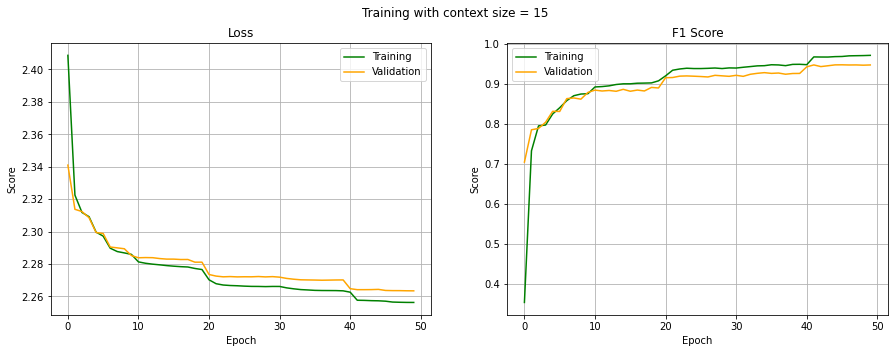

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9716, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9484, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9716, device='cuda:0'),
 tensor(0.9483, device='cuda:0'),
 tensor(0.9484, device='cuda:0'))

## Heatmap

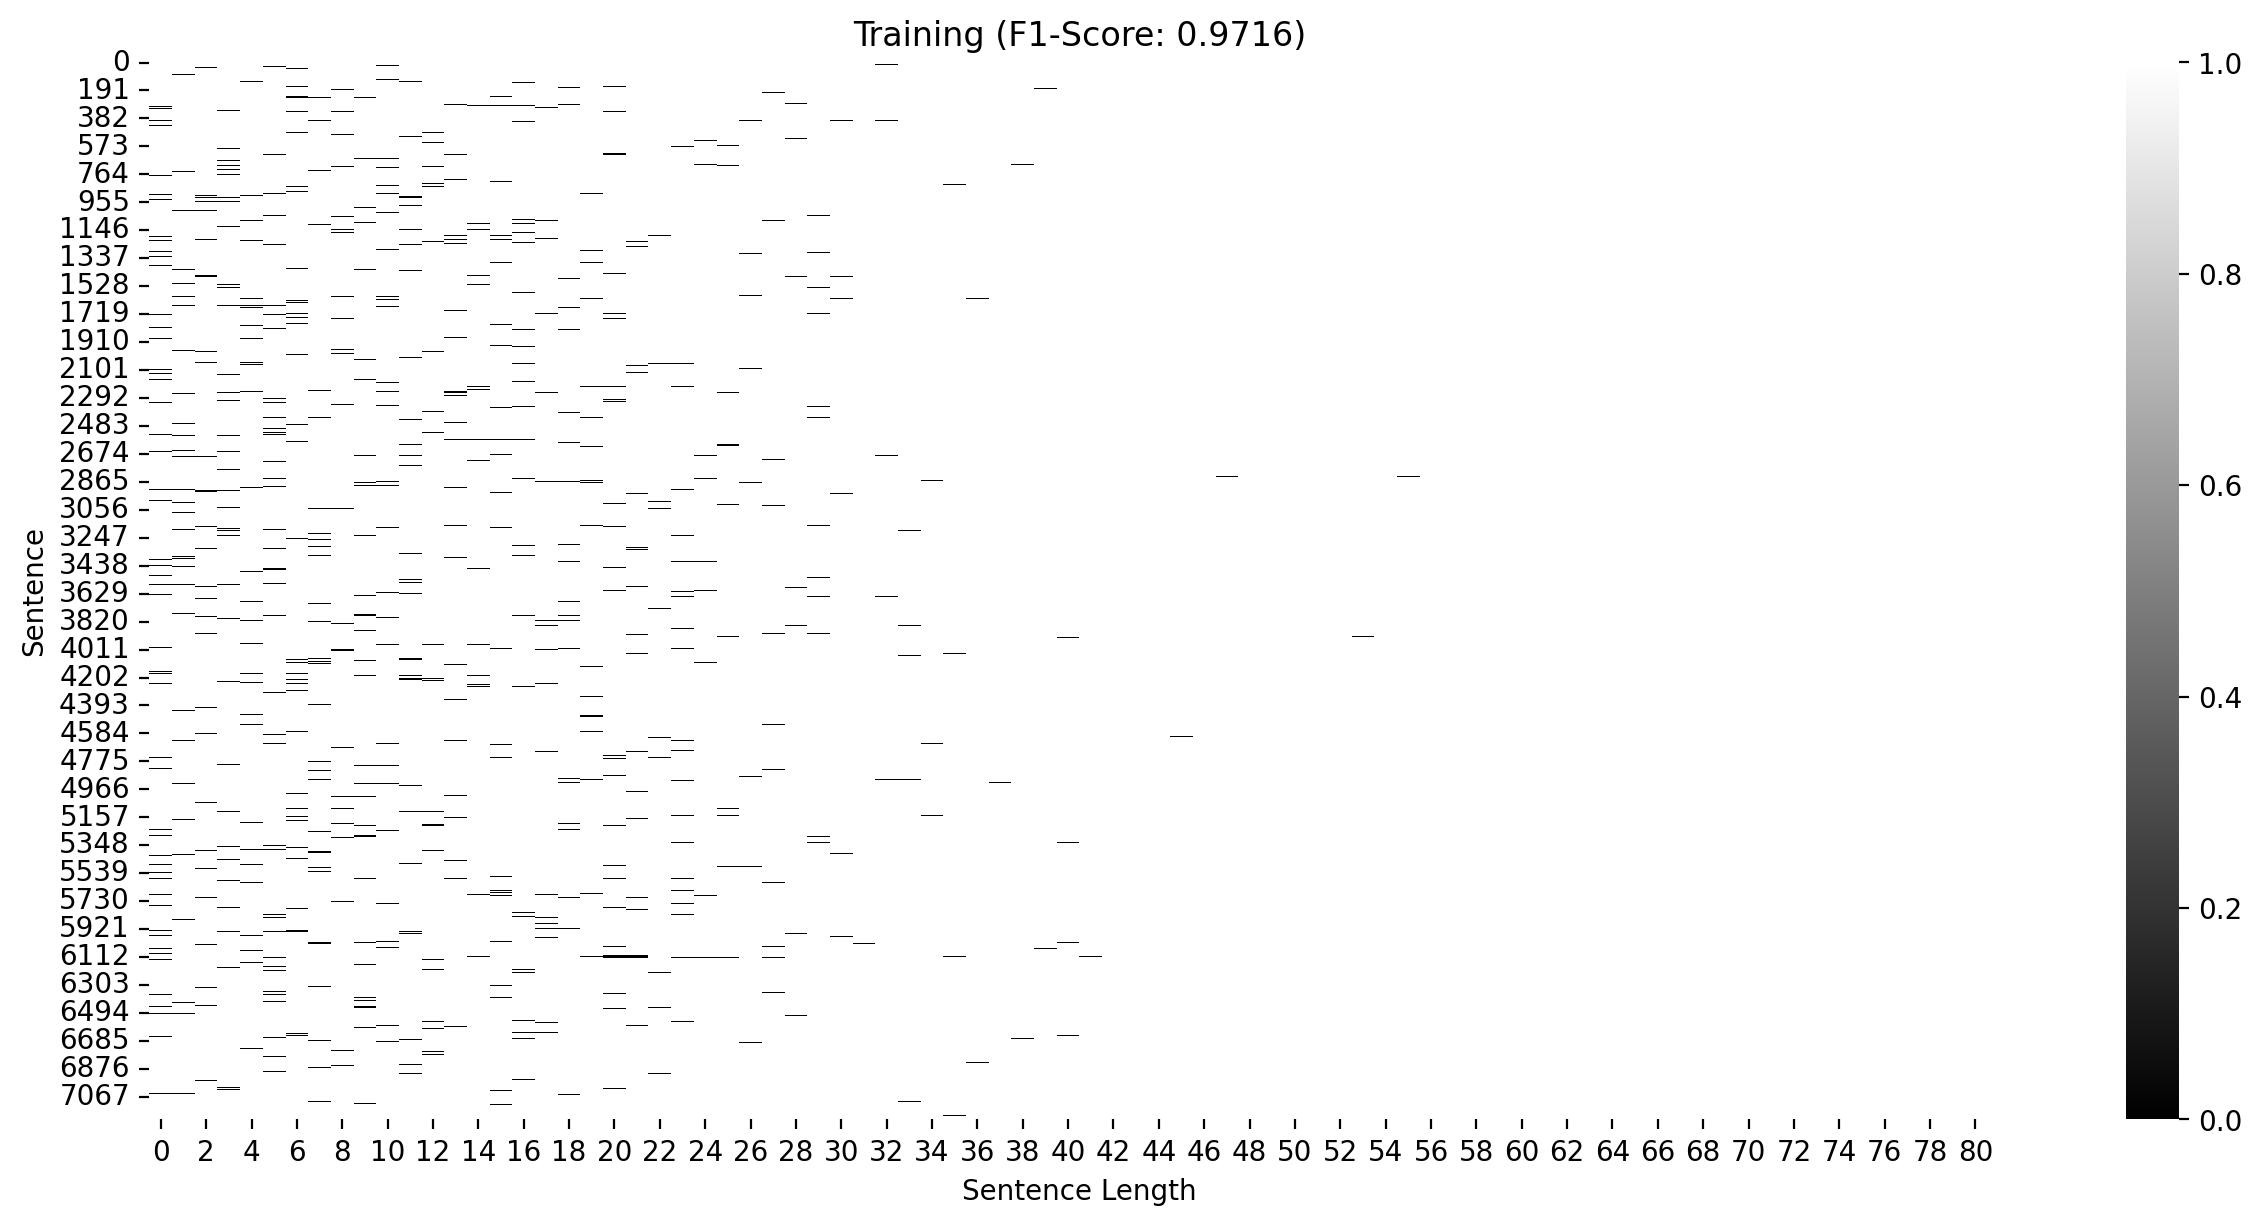

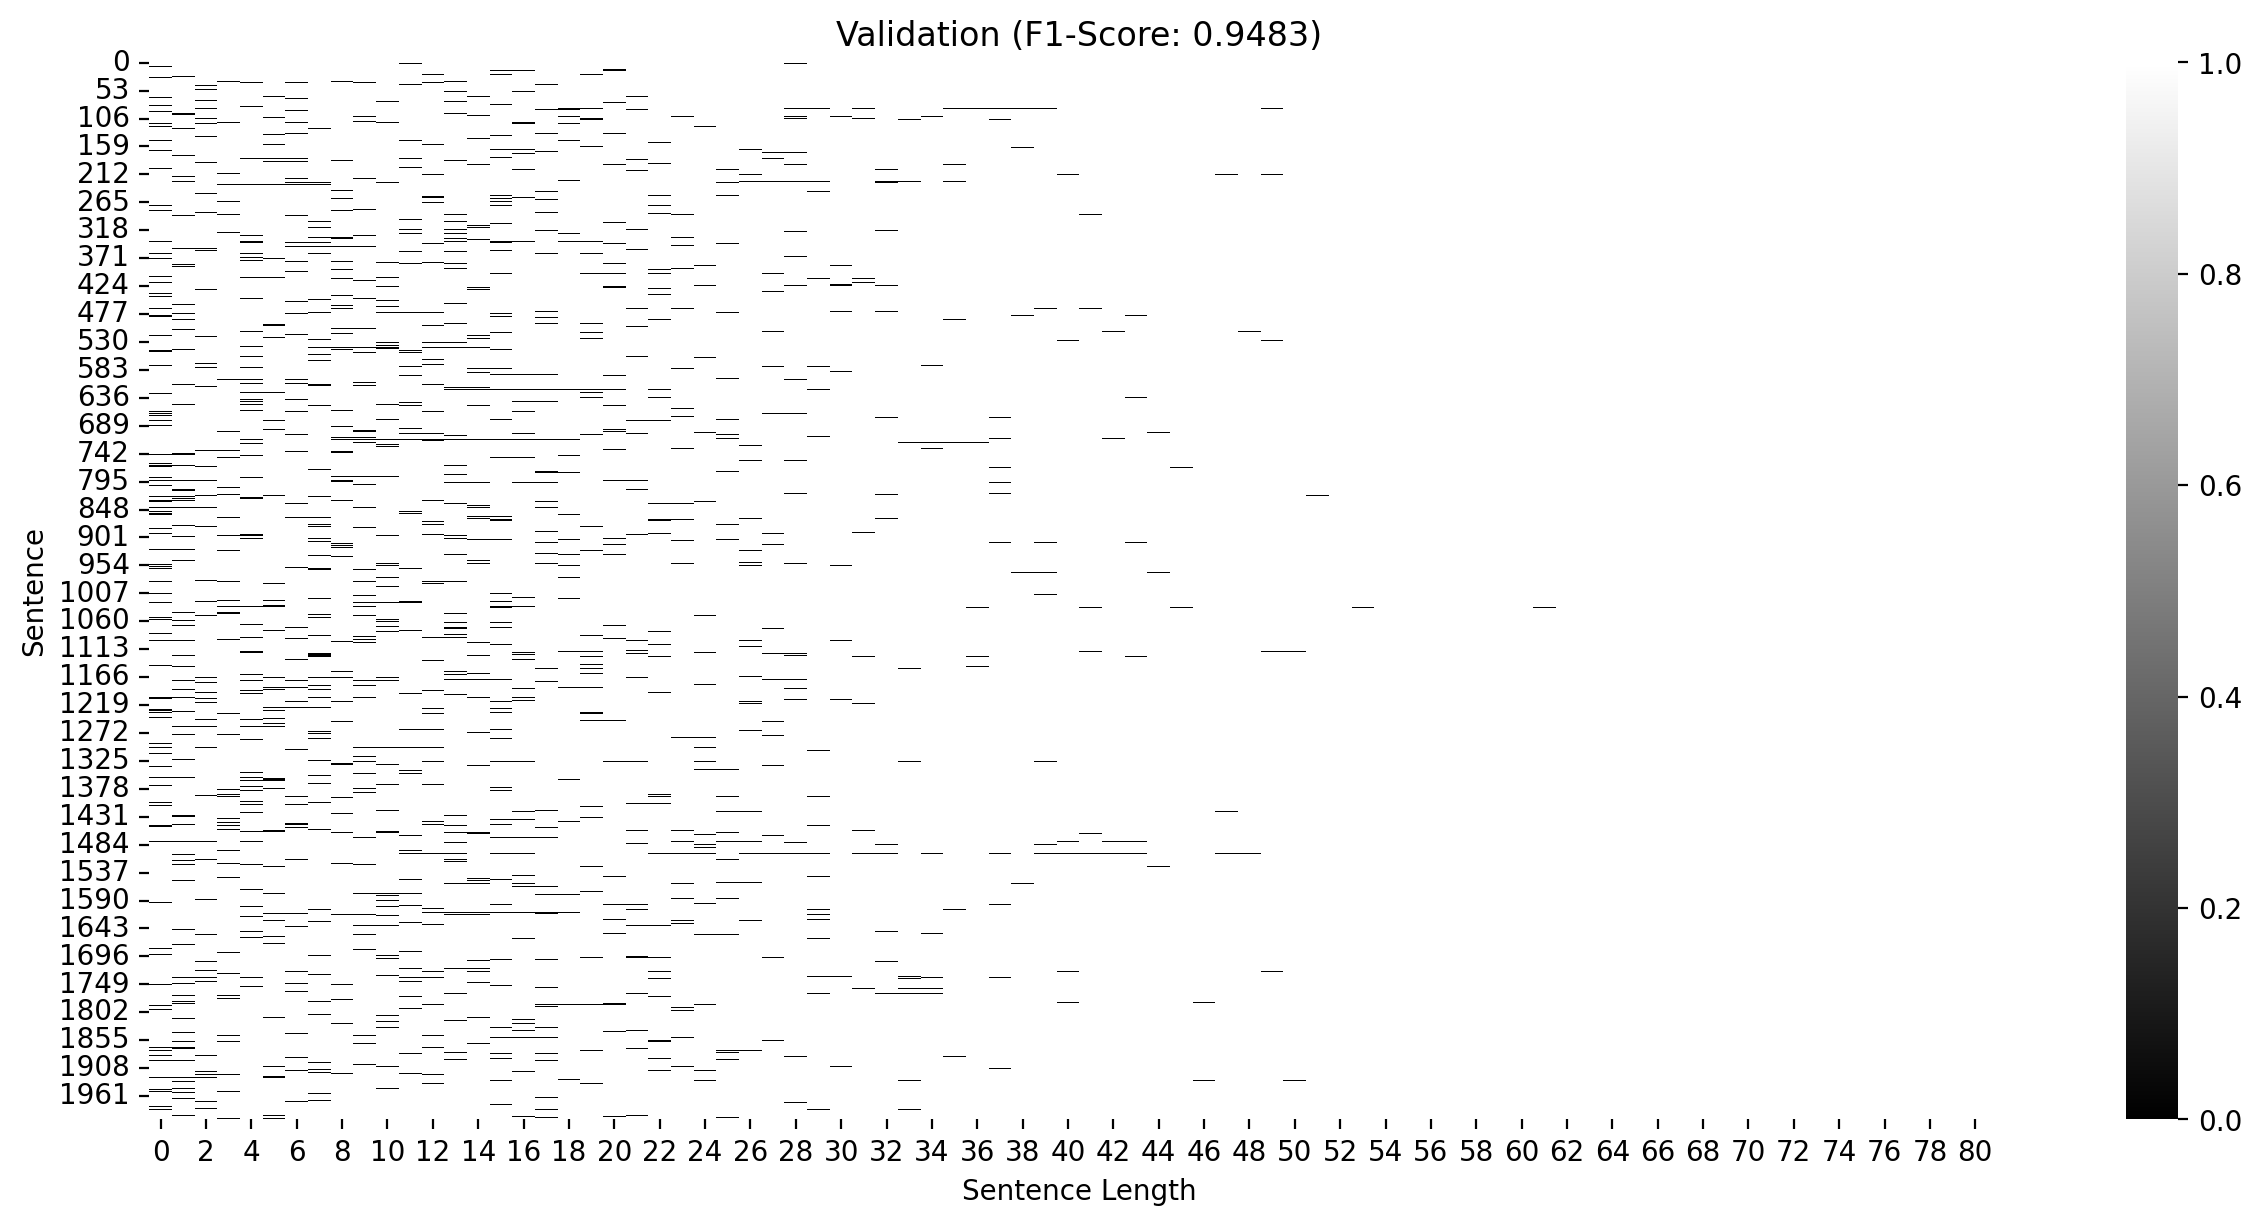

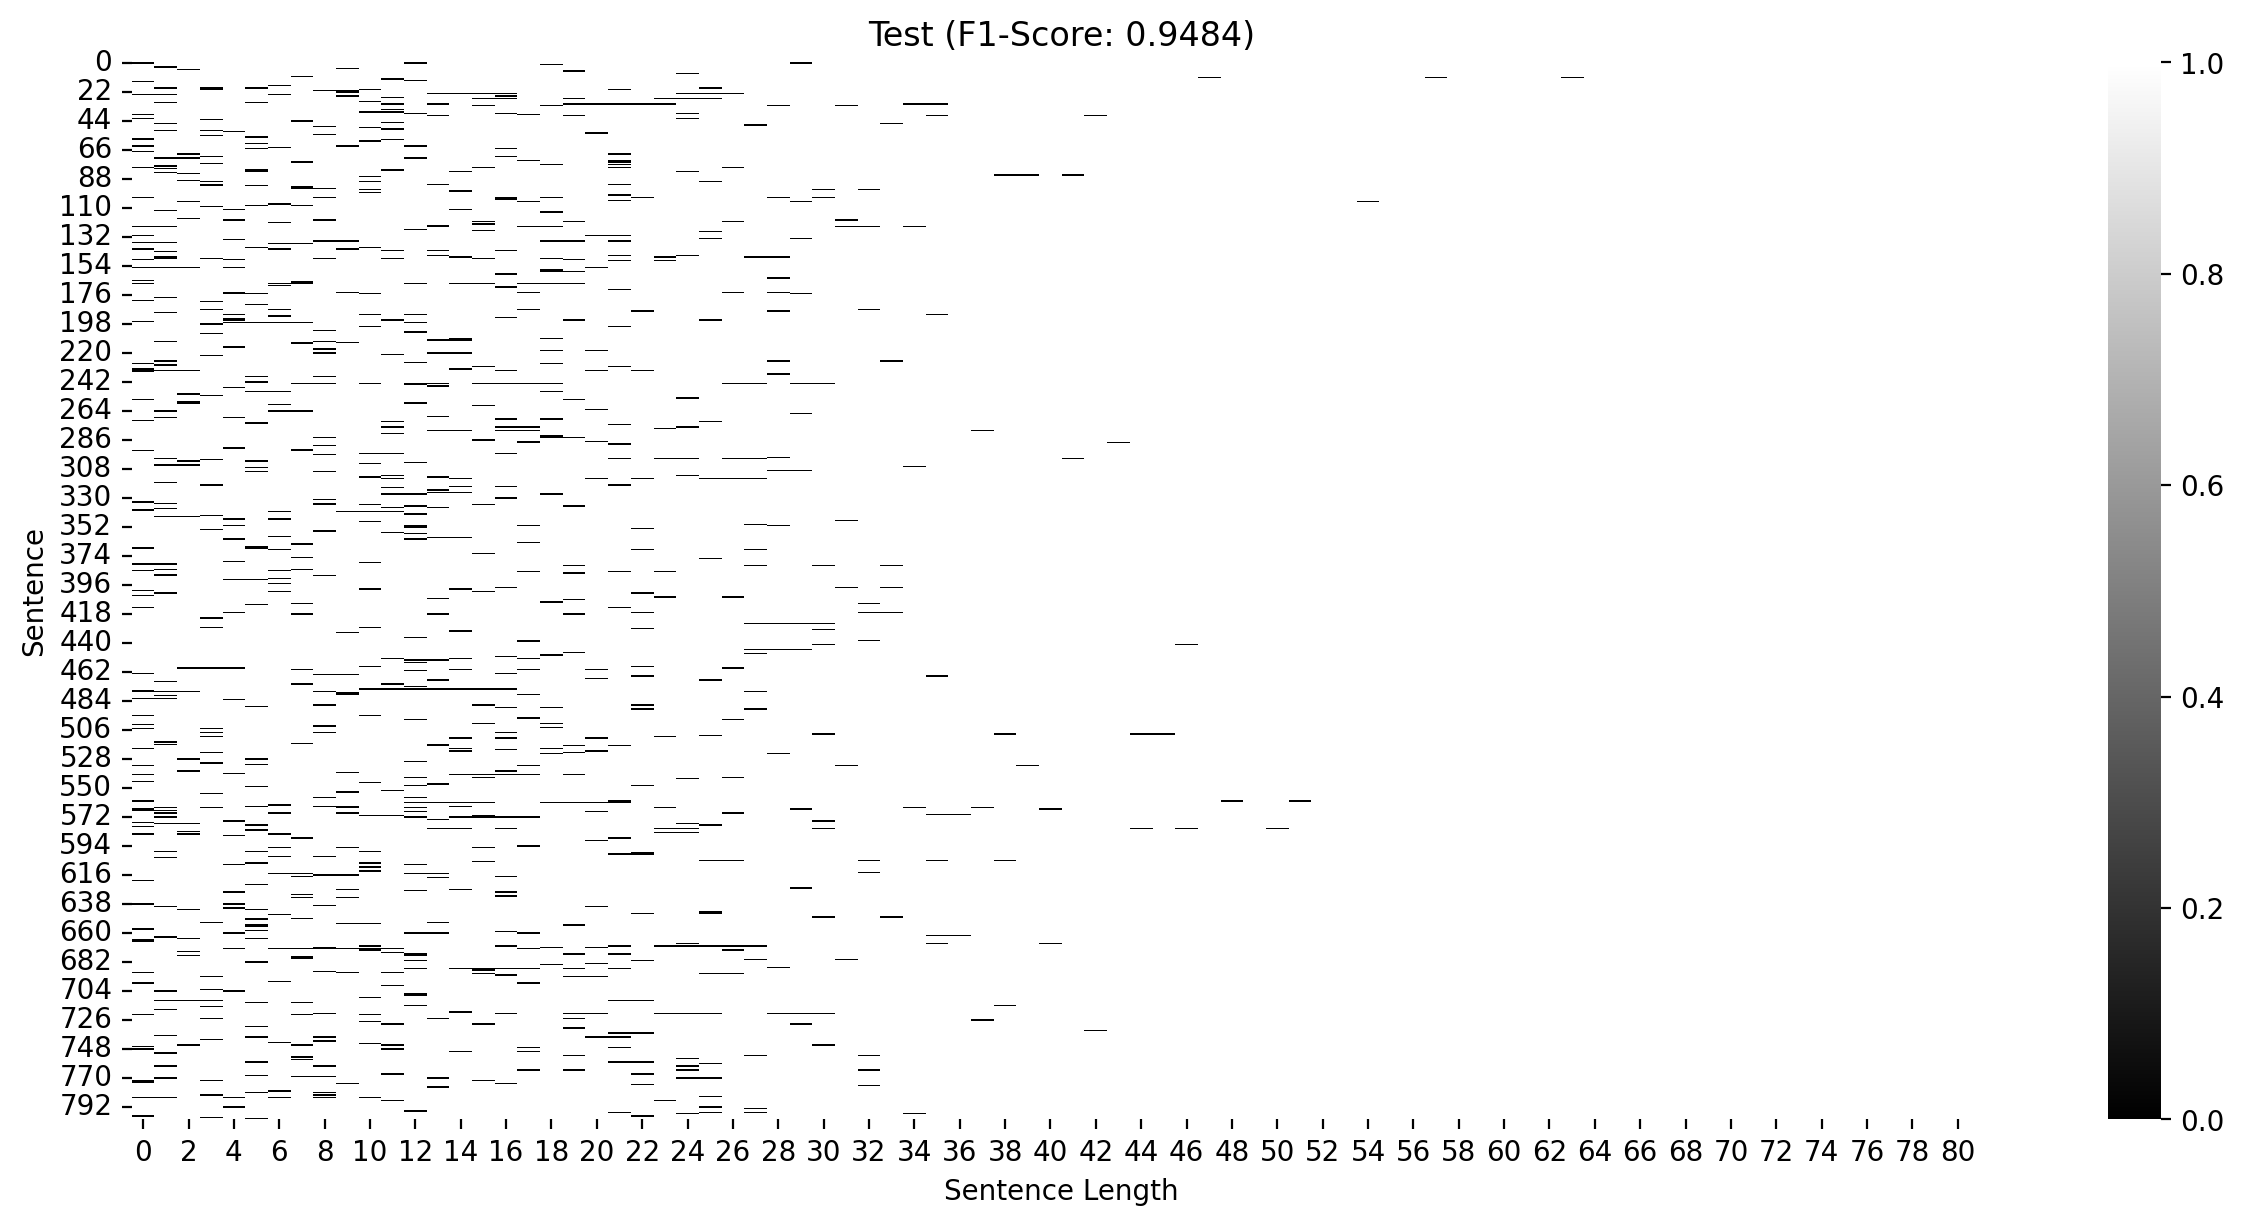

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


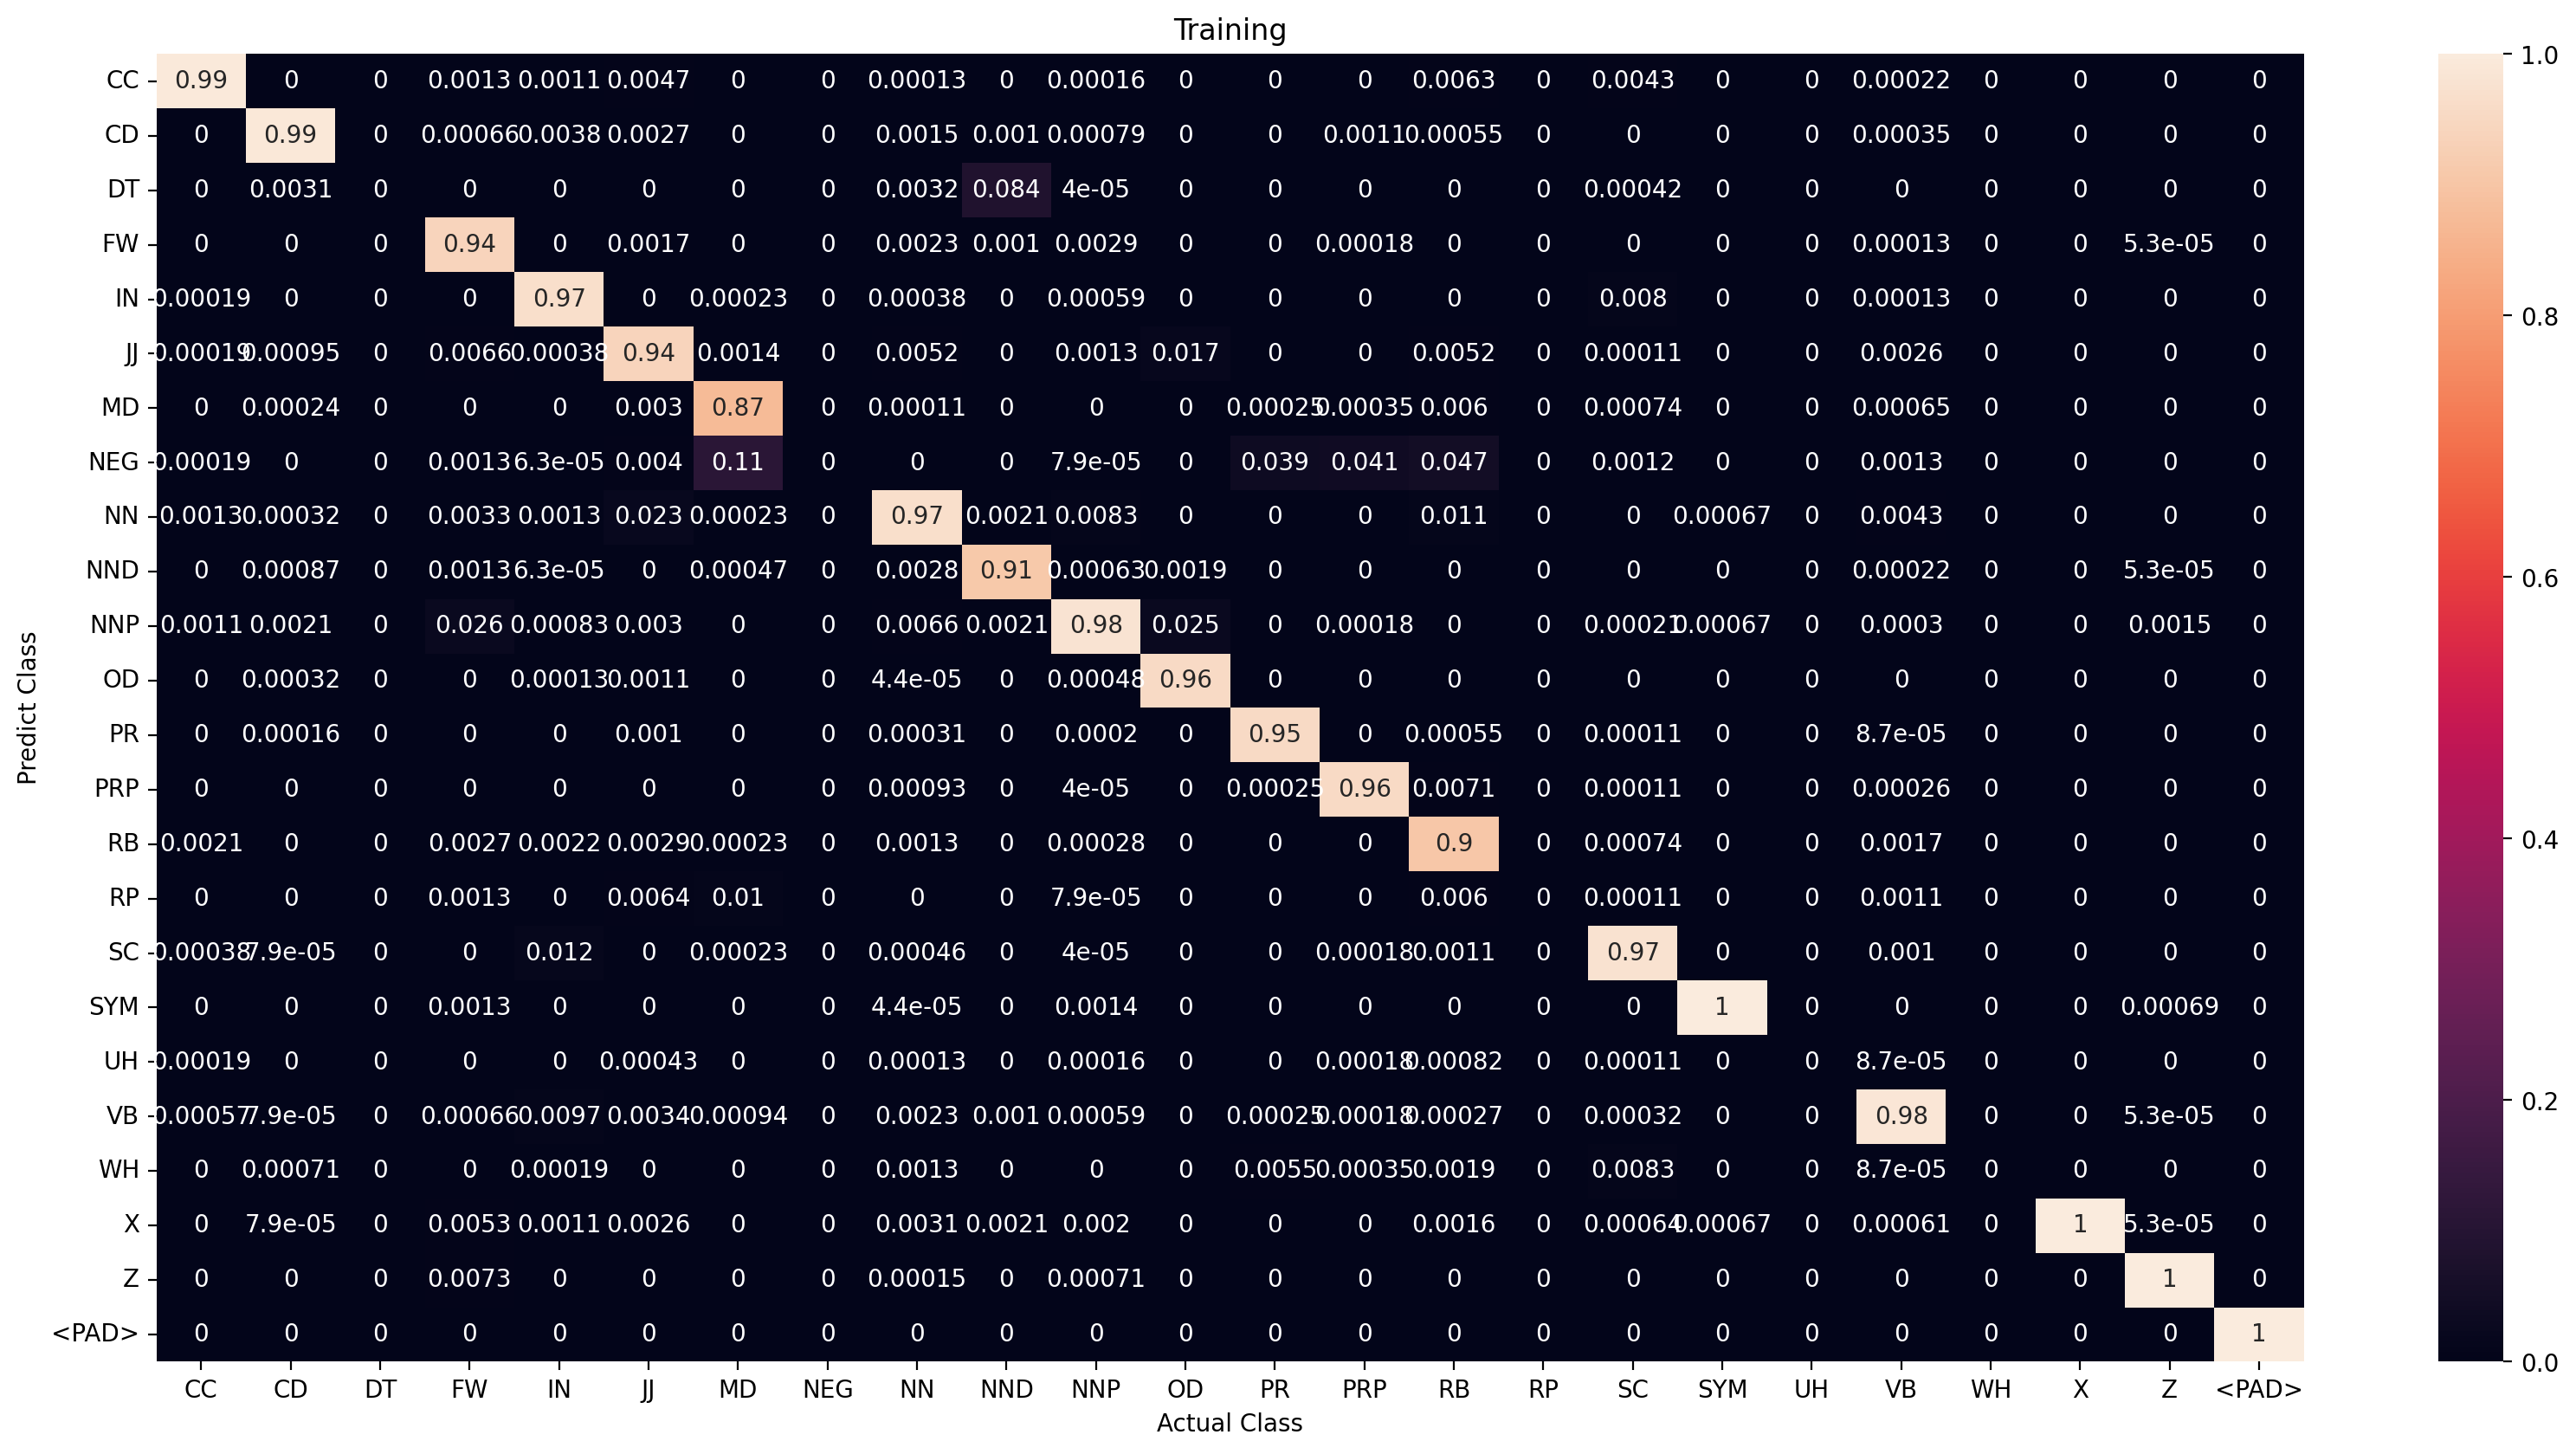

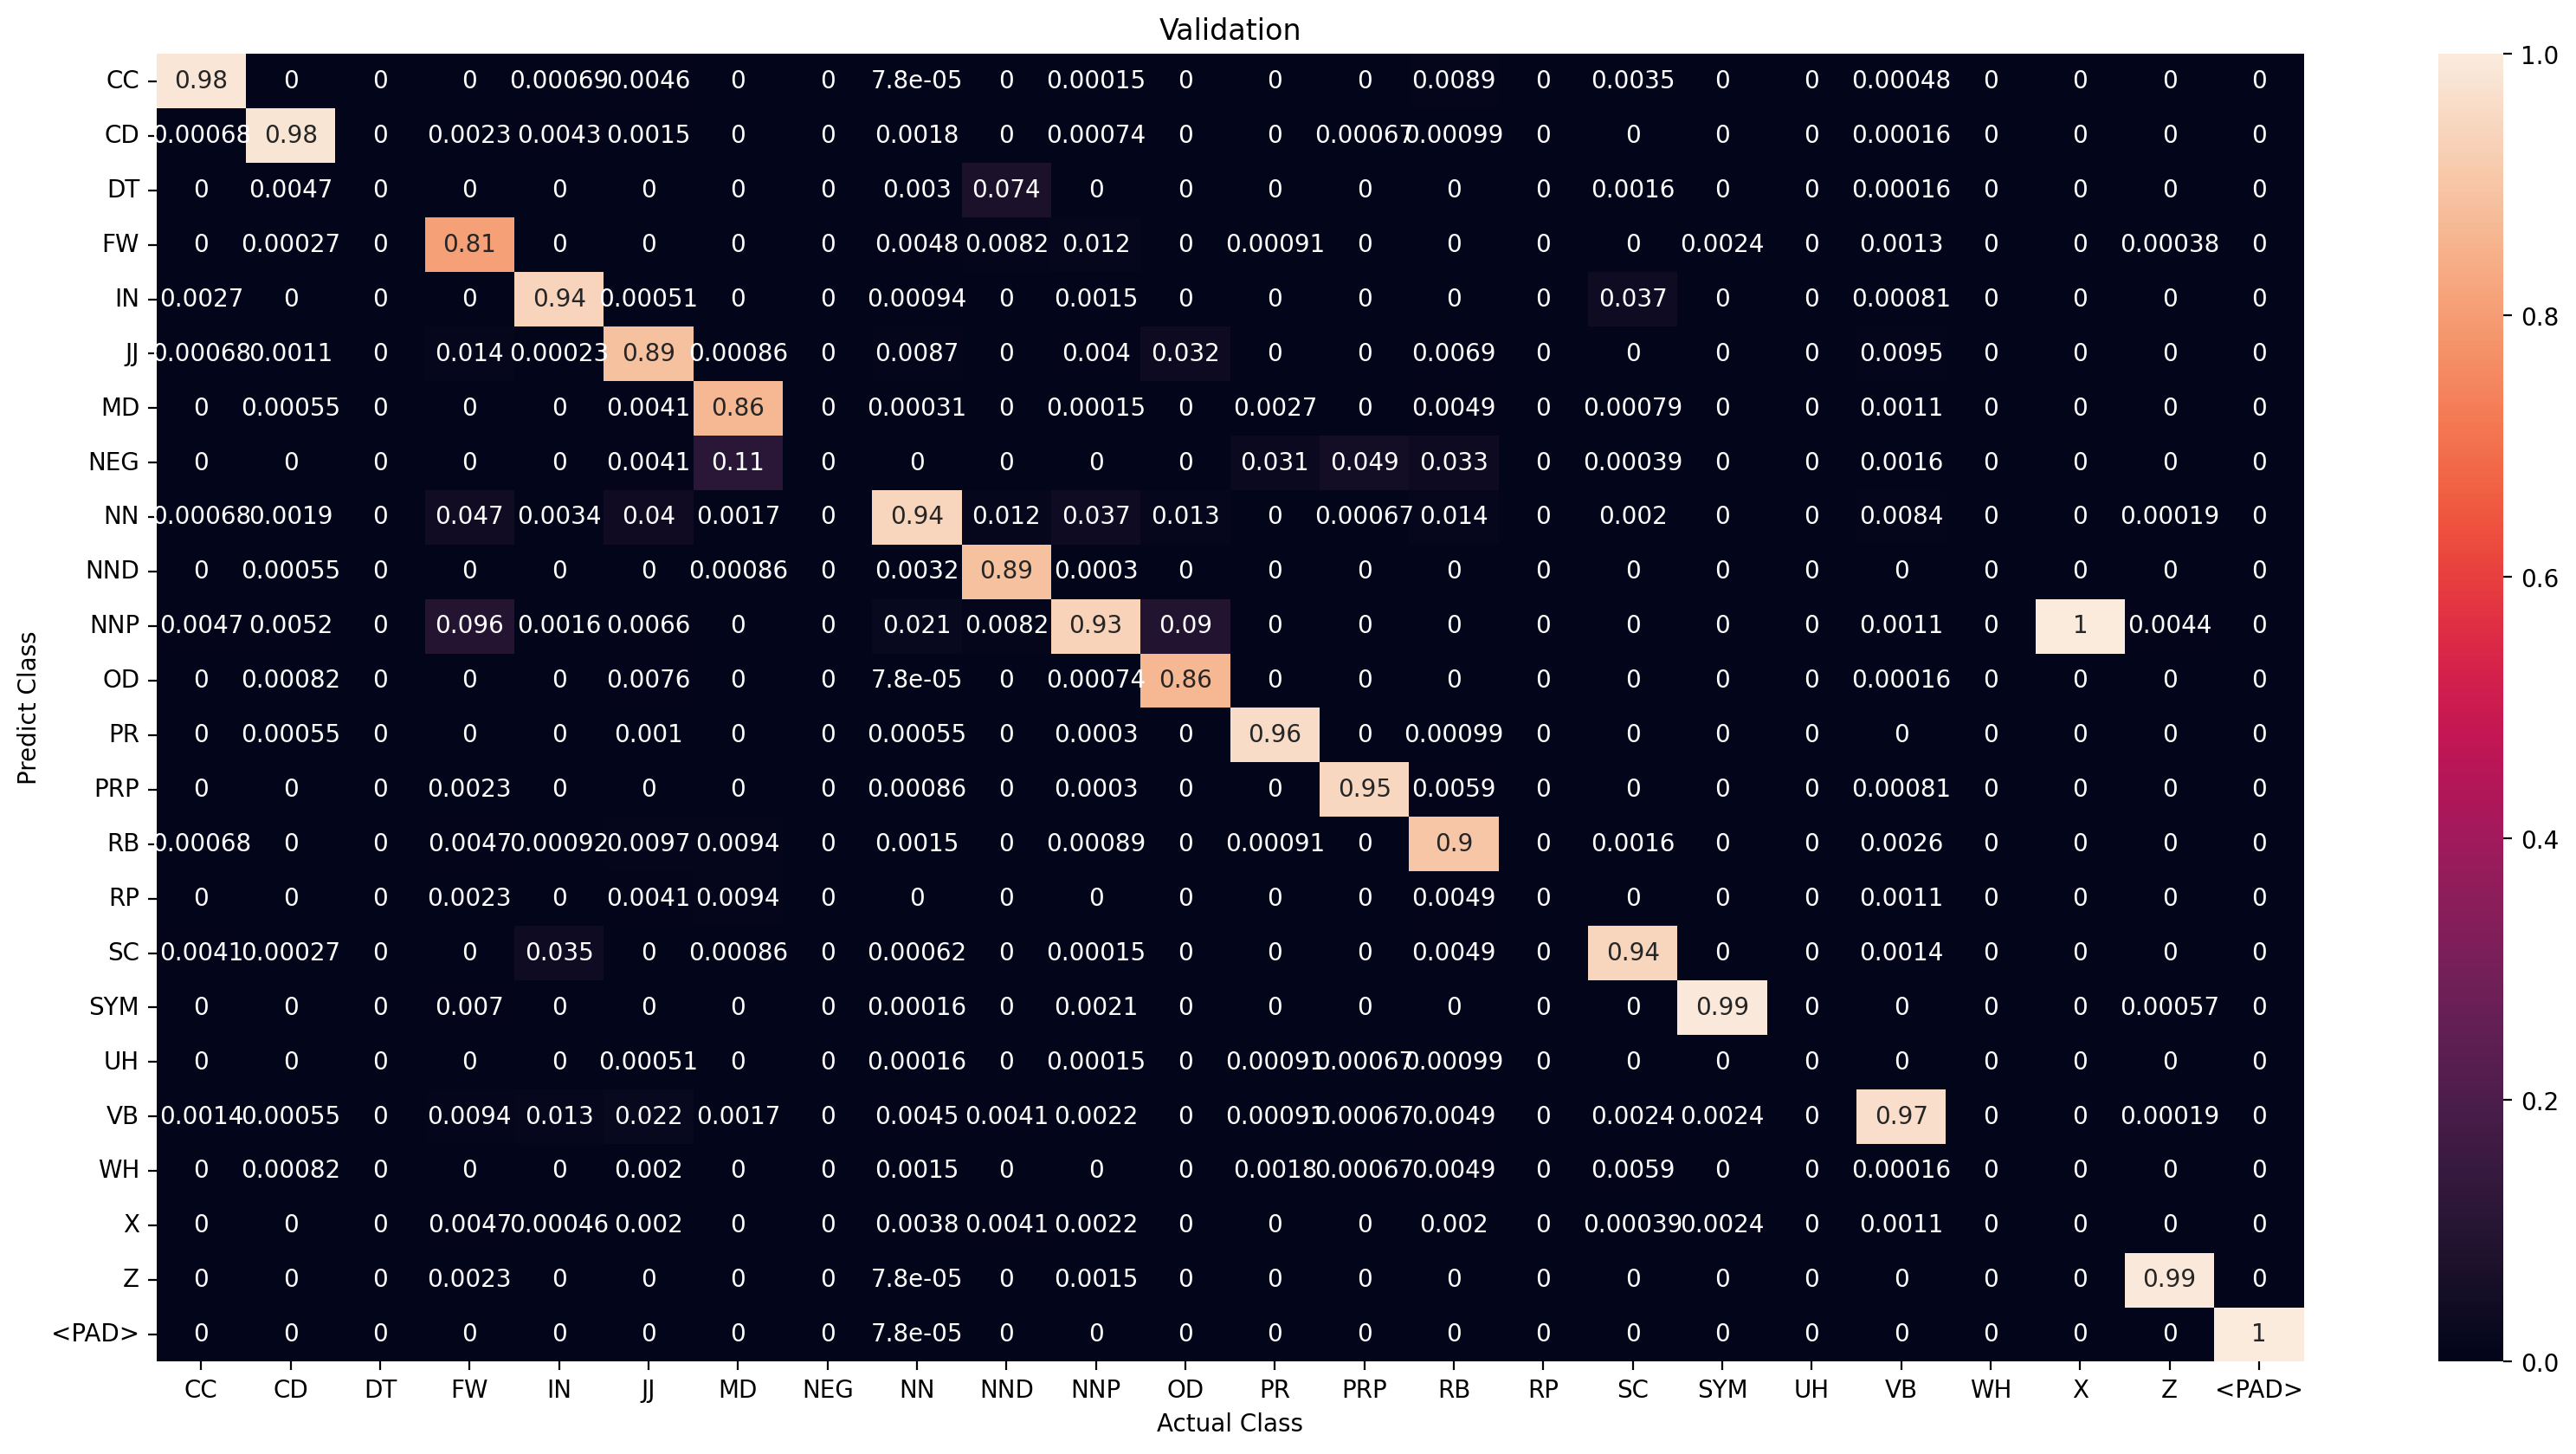

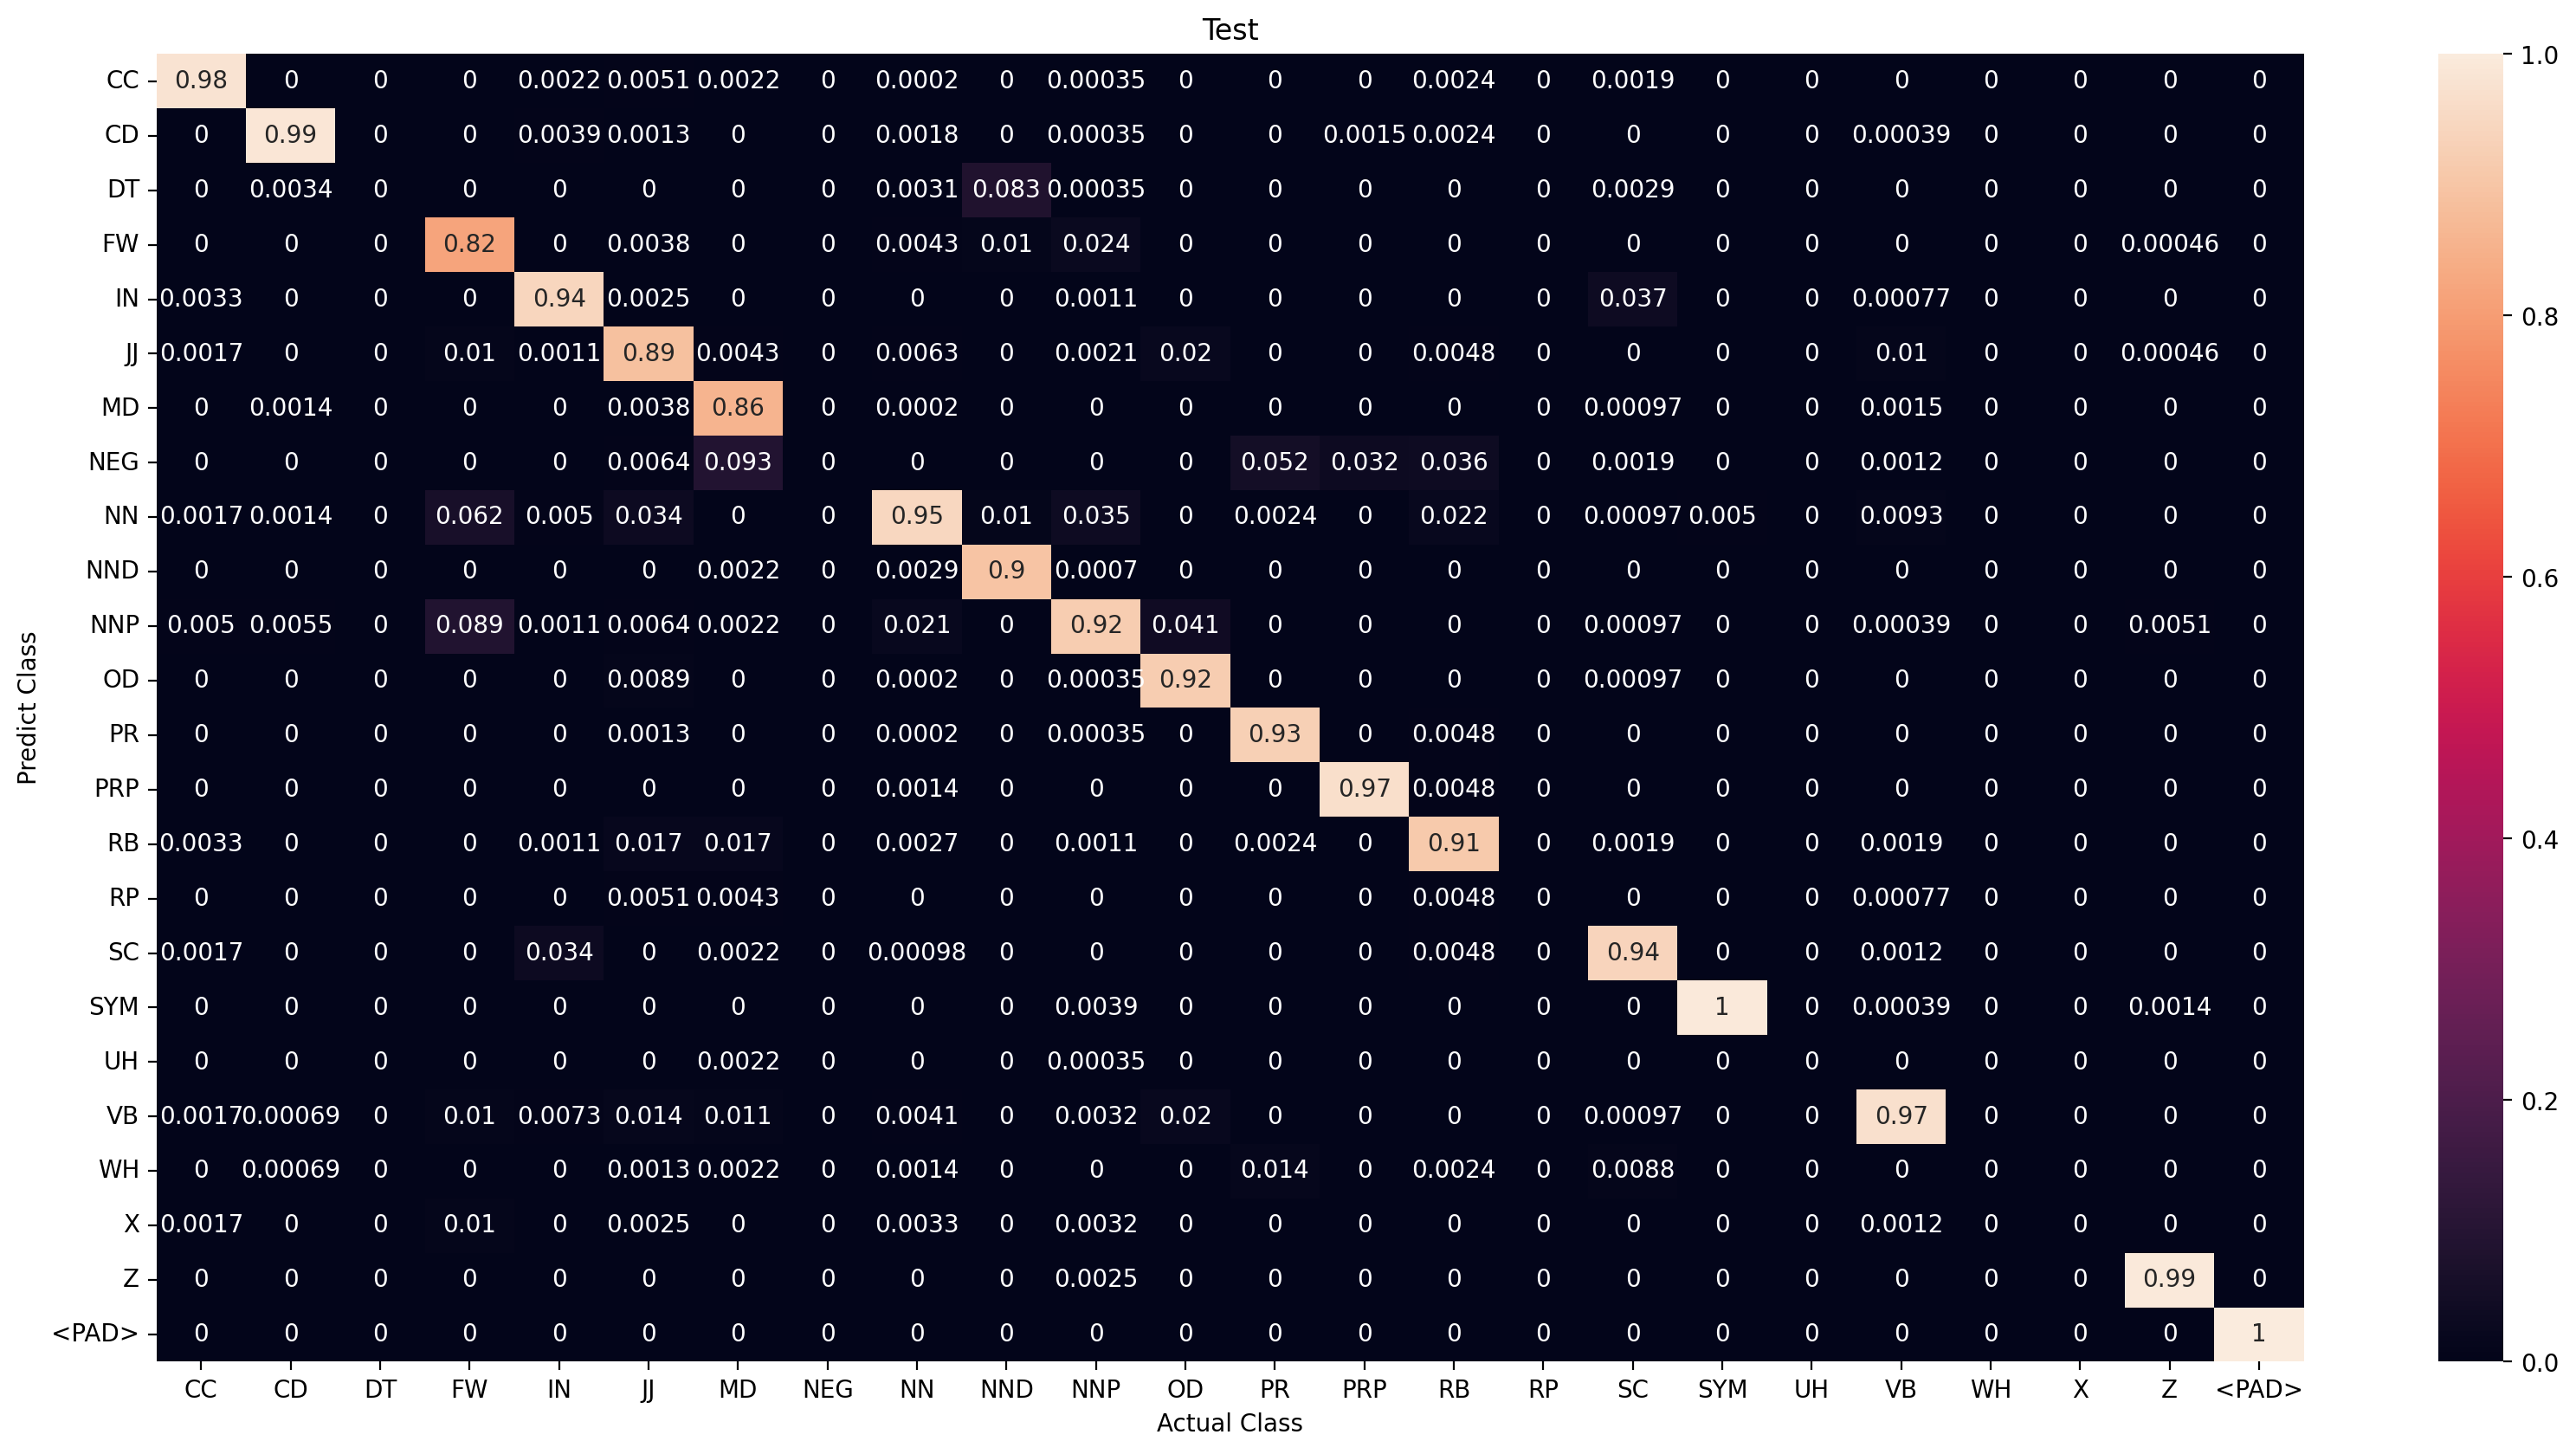

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5215       | CC    : 131      |
| CD    : 12730  | CD    : 12547      | CD    : 183      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1416       | FW    : 198      |
| IN    : 15342  | IN    : 15229      | IN    : 113      |
| JJ    : 6981   | JJ    : 6589       | JJ    : 392      |
| MD    : 3799   | MD    : 3723       | MD    : 76       |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43822      | NN    : 547      |
| NND   : 1047   | NND   : 880        | NND   : 167      |
| NNP   : 25175  | NNP   : 24714      | NNP   : 461      |
| OD    : 524    | OD    : 496        | OD    : 28       |
| PR    : 3880   | PR    : 3847       | PR    : 33       |
| PRP   : 5471   | PRP   : 5394       | PRP   : 77       |
| RB    : 3477   | RB    : 3292       | RB    : 185      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8, 19, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11119
Wrong prediction            : 687
Percentage correct oov pred : 94.18092495341351

Validation
Number OOV token            : 3366
Correct prediction          : 2998
Wrong prediction            : 368
Percentage correct oov pred : 89.06714200831848

Test
Number OOV token            : 1390
Correct prediction          : 1229
Wrong prediction            : 161
Percentage correct oov pred : 88.41726618705036



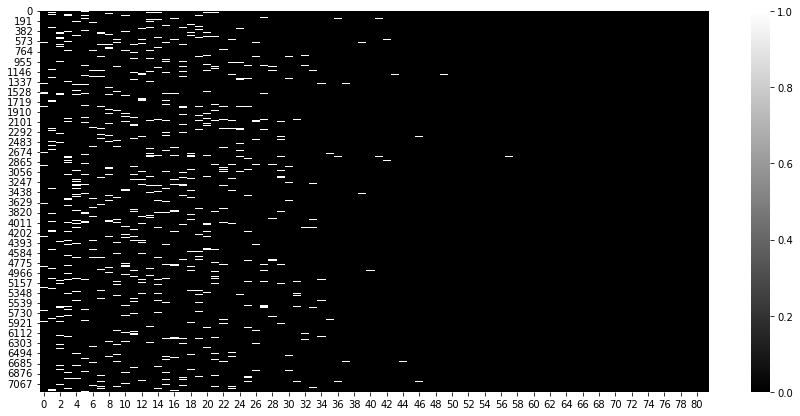

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

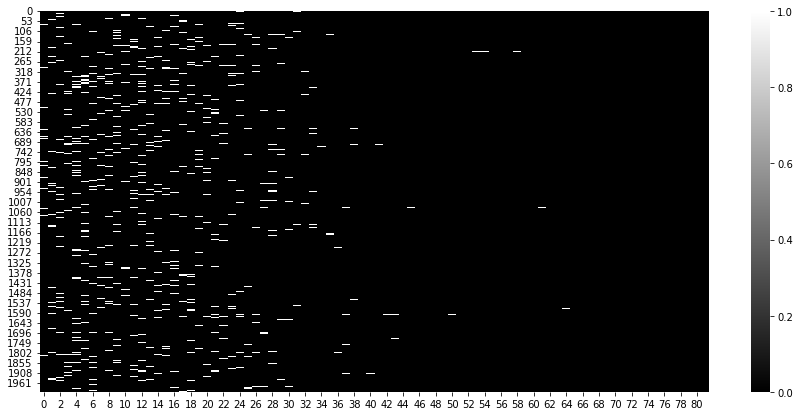

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

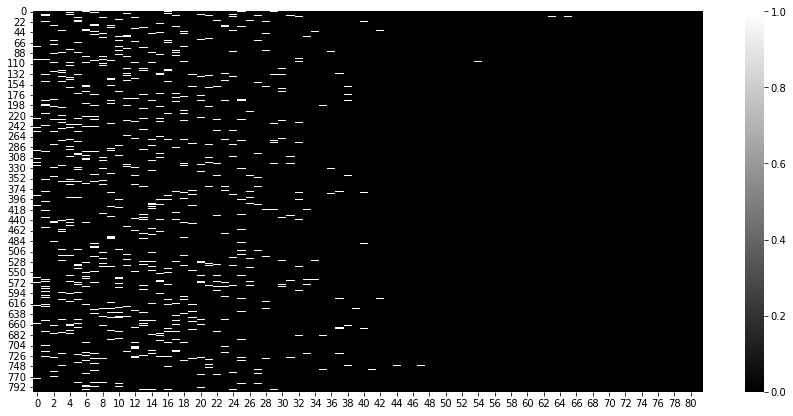

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);